# <center>Train Anomaly Detection with LSTM Autoencoder</center>


An LSTM Autoencoder for anomaly detection utilizes LSTM cells and autoencoder architecture to identify abnormal patterns in sequential data.

1. <b>Encoding</b>: The LSTM encoder captures temporal patterns in the input data, compressing it into a lower-dimensional representation.
2. <b>Decoding</b>: The LSTM decoder attempts to reconstruct the original sequence from the compressed representation.
3. <b>Training</b>: During training, the model learns to minimize reconstruction errors for normal sequences.
4. <b>Anomaly Detection</b>: High reconstruction errors indicate anomalies in new sequences during testing.
5. <b>Unsupervised</b>: The model learns from normal data, making it adaptable for various domains without labeled anomalies.

### Libraries and Settings

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

import warnings

In [53]:
# settings
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,4)
tf.compat.v1.enable_v2_behavior()
sns.set(style='whitegrid', palette='muted')
warnings.filterwarnings('ignore')
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.12.0


## Data Preprocessing

### Load Data

In [8]:
filename = './data/Dipped Only at the end.xlsx'
data = pd.read_excel(filename, header=0, parse_dates=True, squeeze=True)
data.head()

,Times,DistanceVehicle,"a:z(Carbody)(0,0,0)","a:z(Carbody/track)(7,0,0)","a:z(Carbody/track)(-7,0,0)",a:z(Bogie1.RangkaBogie),a:z(Bogie1.WSet1.WSet),a:z(Bogie1.WSet1.WSet)(Axlebox)
0,0.000000,0.000000,0.000129,0.000227,0.000032,0.000347,0.102785,0.112035
1,0.002507,0.055704,-0.000526,-0.000273,-0.000778,0.109149,0.423820,0.430023
2,0.005007,0.111252,0.000098,0.002276,-0.002080,0.036520,0.141978,0.146539
3,0.007507,0.166799,0.001200,0.005018,-0.002617,0.006896,0.059693,0.061051
4,0.010069,0.223734,0.001600,0.004632,-0.001431,-0.052968,0.072001,0.072509


### Data Cleansing 

No null values

In [9]:
data.isnull().sum()

Times                              0
DistanceVehicle                    0
a:z(Carbody)(0,0,0)                0
a:z(Carbody/track)(7,0,0)          0
a:z(Carbody/track)(-7,0,0)         0
a:z(Bogie1.RangkaBogie)            0
a:z(Bogie1.WSet1.WSet)             0
a:z(Bogie1.WSet1.WSet)(Axlebox)    0
dtype: int64

### EDA (Explanatory Data Analytics)

In [10]:
data.shape

(10656, 8)

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Times'], y=data['a:z(Carbody/track)(-7,0,0)'],
                    mode='lines',
                    name='Acceleration'))
fig.update_layout(showlegend=True)
fig.show()

Text(0, 0.5, 'Acceleration')

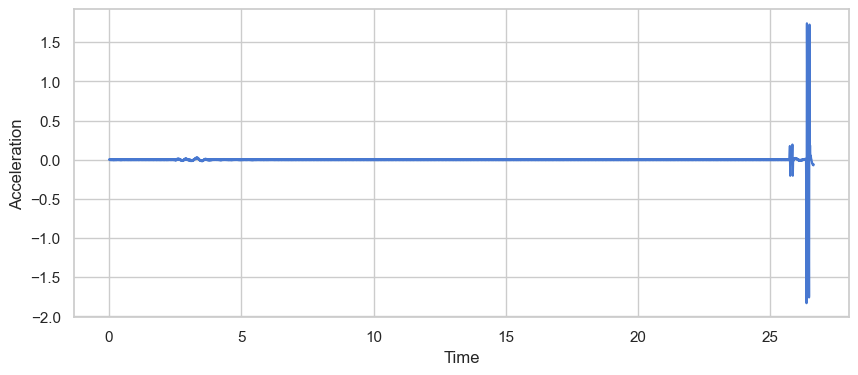

In [12]:
sns.lineplot(x=data['Times'], y=data['a:z(Carbody/track)(-7,0,0)'])
plt.xlabel('Time')
plt.ylabel('Acceleration')

In [13]:
ms_period = 40
s_period = ms_period * 10

print('Data size: ', len(data))
print('Number of data per ms: ', ms_period)
print('Number of data per second: ', s_period)
print('Number of ms: ' , len(data) / ms_period)
print('Number of seconds: ' , len(data) / s_period)

Data size:  10656
Number of data per ms:  40
Number of data per second:  400
Number of ms:  266.4
Number of seconds:  26.64


### Feature Engineering, Feature Selection, Data Splitting

#### Feature Selection

In [14]:
df = data[['a:z(Carbody/track)(-7,0,0)']]
df.columns = ['Acceleration']
df.index = data['Times']
df

,Acceleration
Times,
0.000000,0.000032
0.002507,-0.000778
0.005007,-0.002080
0.007507,-0.002617
0.010069,-0.001431
...,...
26.627522,-0.073323
26.630116,-0.072493
26.632616,-0.068961


#### Split

In [15]:
ratio = 0.8
train_size = int(data.shape[0] * ratio)
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]

print('Train size: ', ratio)

print('\n\nTRAIN SET:  from  ' + str(np.min(train.index)) + '  to  ' +str(np.max(train.index)))
print('Data size: ', train.shape[0])

print('\n\nTEST SET:  from  ' + str(np.min(test.index)) + '  to  ' +str(np.max(test.index)))
print('Data size: ', test.shape[0])

Train size:  0.8


TRAIN SET:  from  0.0  to  21.30752182006836
Data size:  8524


TEST SET:  from  21.310022354125977  to  26.637554168701172
Data size:  2132


#### Feature Engineering

Standardize data by removing the mean and scaling to unit variance.

In [16]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Acceleration']])

train = scaler.transform(train[['Acceleration']])
test = scaler.transform(test[['Acceleration']])

In [17]:
def split_into_windows(X, length):
  windows = []
  for start in range(0, len(X) - length + 1):
    windows.append(X[start: start + length])
  return np.array(windows)

In [21]:
window_length = 40

X_train = split_into_windows(train, window_length)
X_test = split_into_windows(test, window_length)

_, input_length, input_dim = X_train.shape

In [22]:
X_train.shape

(8485, 40, 1)

## Model: LSTM Autoencoder

In [63]:
# params
dim_hidden1 = 20 # 1/2 the length of one window
dim_hidden2 = 10 # 1/4 the length of one window


# model 1
model1 = Sequential()
model1.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model1.add(Dropout(0.2))
model1.add(TimeDistributed(Dense(input_dim)))

# summary
model1.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 40, 20)            1760      
                                                                 
 dropout_58 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_67 (LSTM)              (None, 40, 10)            1240      
                                                                 
 dropout_59 (Dropout)        (None, 40, 10)            0         
                                                                 
 lstm_68 (LSTM)              (None, 40, 10)            840       
                                                                 
 dropout_60 (Dropout)        (None, 40, 10)            0         
                                                                 
 lstm_69 (LSTM)              (None, 40, 20)          

In [64]:
# model 2
model2 = Sequential()
model2.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim)))
model2.add(Dropout(0.2))
model2.add(RepeatVector(input_length))
model2.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(TimeDistributed(Dense(input_dim)))

# summary
model2.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 20)                1760      
                                                                 
 dropout_62 (Dropout)        (None, 20)                0         
                                                                 
 repeat_vector_15 (RepeatVec  (None, 40, 20)           0         
 tor)                                                            
                                                                 
 lstm_71 (LSTM)              (None, 40, 20)            3280      
                                                                 
 dropout_63 (Dropout)        (None, 40, 20)            0         
                                                                 
 time_distributed_19 (TimeDi  (None, 40, 1)            21        
 stributed)                                          

In [65]:
# model 3
model3 = Sequential()
model3.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=False))
model3.add(Dropout(0.2))
model3.add(RepeatVector(input_length))
model3.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model3.add(Dropout(0.2))
model3.add(TimeDistributed(Dense(input_dim)))

# summary
model3.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 40, 20)            1760      
                                                                 
 dropout_64 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_73 (LSTM)              (None, 10)                1240      
                                                                 
 dropout_65 (Dropout)        (None, 10)                0         
                                                                 
 repeat_vector_16 (RepeatVec  (None, 40, 10)           0         
 tor)                                                            
                                                                 
 lstm_74 (LSTM)              (None, 40, 10)            840       
                                                     

### Fitting Model

In [66]:
NUM_EPOCHS=50
BATCH_SIZE=40
validation_split = 0.1
es = EarlyStopping(monitor='val_loss', patience=5)

models = [model1, model2, model3]

# fitting
histories = []
i = 1
for model in models:
  print('Model ', i)
  history = model.fit(X_train, X_train, 
              batch_size = BATCH_SIZE, 
              epochs = NUM_EPOCHS, 
              validation_split = validation_split, 
              # callbacks = [es]
              )
  histories.append(history)
  i += 1

Model  1
Epoch 1/50
191/191 [==============================] - 19s 61ms/step - loss: 0.7526 - accuracy: 0.0000e+00 - val_loss: 0.3044 - val_accuracy: 0.0000e+00
Epoch 2/50
191/191 [==============================] - 11s 57ms/step - loss: 0.4240 - accuracy: 0.0000e+00 - val_loss: 0.2321 - val_accuracy: 0.0000e+00
Epoch 3/50
191/191 [==============================] - 11s 57ms/step - loss: 0.3543 - accuracy: 0.0000e+00 - val_loss: 0.1867 - val_accuracy: 0.0000e+00
Epoch 4/50
191/191 [==============================] - 11s 57ms/step - loss: 0.3276 - accuracy: 0.0000e+00 - val_loss: 0.1797 - val_accuracy: 0.0000e+00
Epoch 5/50
191/191 [==============================] - 11s 58ms/step - loss: 0.3111 - accuracy: 0.0000e+00 - val_loss: 0.1719 - val_accuracy: 0.0000e+00
Epoch 6/50
191/191 [==============================] - 11s 59ms/step - loss: 0.2991 - accuracy: 0.0000e+00 - val_loss: 0.1637 - val_accuracy: 0.0000e+00
Epoch 7/50
191/191 [==============================] - 11s 55ms/step - loss: 0.2

### Training and Validation Loss 

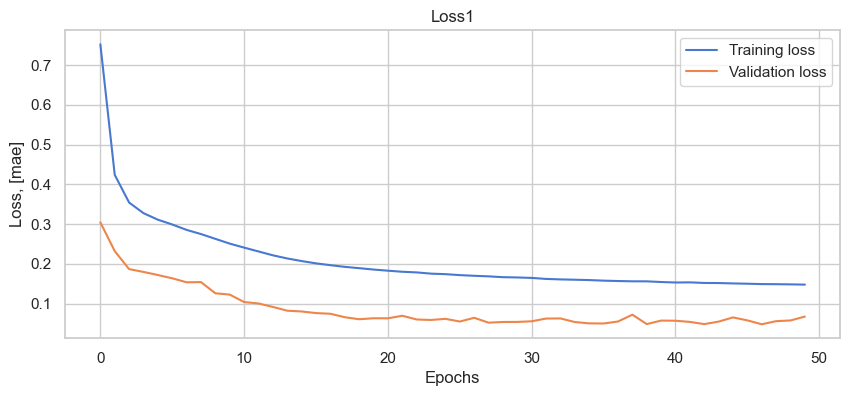

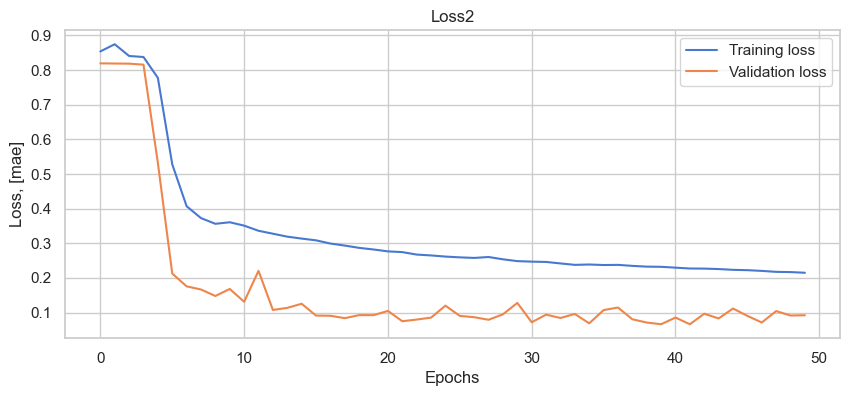

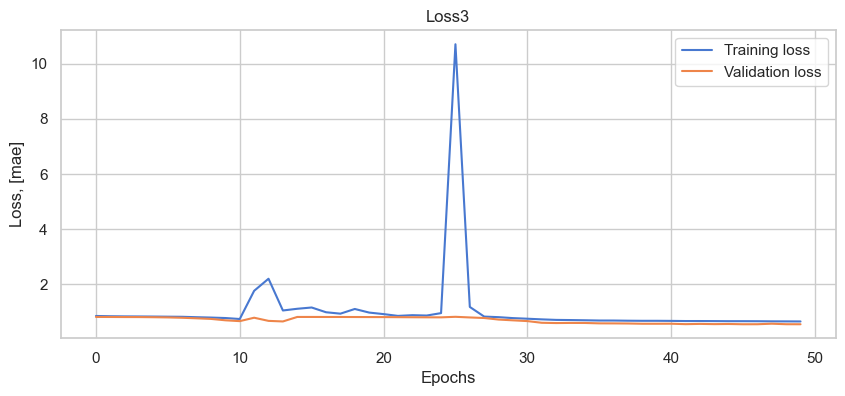

In [67]:
i = 1
for history in histories:
    plt.title(f'Loss{i}') 
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss, [mae]')
    plt.show()
    i += 1

### Reconstruction

In [68]:
pred_x_tests = []
pred_x_trains = []
for model in models:
  pred_x_test = model.predict(X_test)
  pred_x_train = model.predict(X_train)
  pred_x_tests.append(pred_x_test)
  pred_x_trains.append(pred_x_train)

266/266 [==============================] - 4s 14ms/step


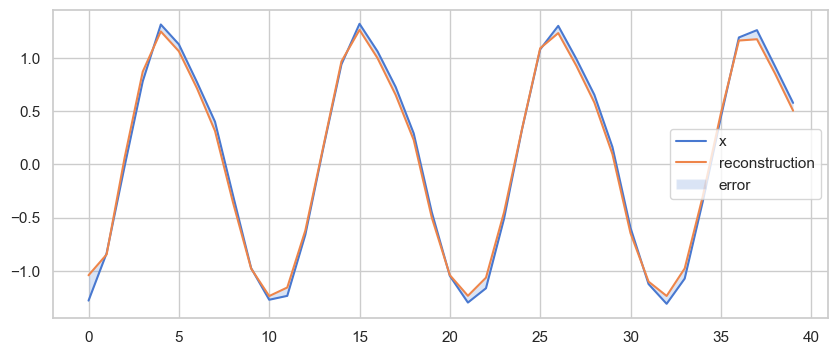

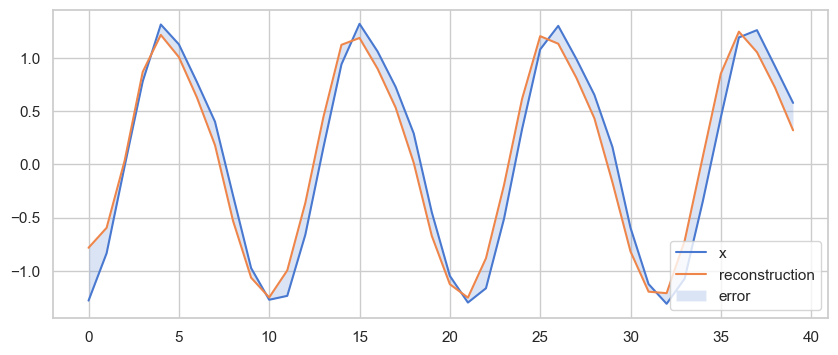

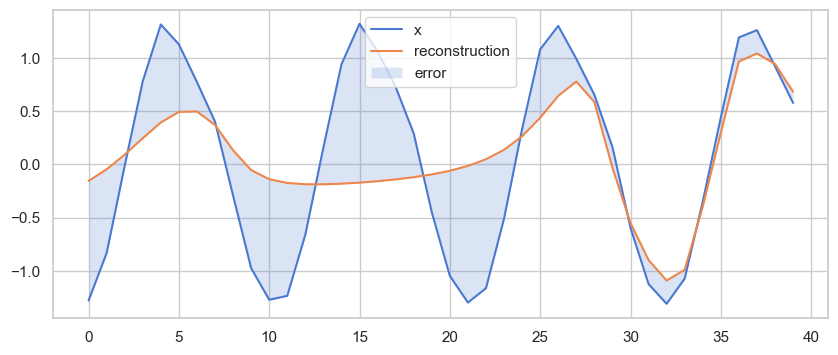

In [70]:
for j in range(len(models)):  
  pred_x_test = pred_x_tests[j]
  for i in range(int(ms_period / window_length)):
    x = X_test[i * window_length].flatten()
    x_pred = pred_x_test[i * window_length].flatten()
    
    plt.plot(x, label='x')
    plt.plot(x_pred, label='reconstruction')
    plt.fill_between(np.arange(window_length), x, x_pred, alpha=0.2, label='error')
    plt.legend()
    plt.show()

### MAE of the Reconstruction

In [71]:
mae = lambda x, x_pred: np.mean(np.abs(x - x_pred), axis=1)

train_mae_losses = []
test_mae_losses = []
for i in range(len(pred_x_tests)):
    train_mae_loss = pd.DataFrame(mae(X_train, pred_x_trains[i]), columns=['Error'])
    test_mae_loss = pd.DataFrame(mae(X_test, pred_x_tests[i]), columns=['Error'])
    train_mae_losses.append(train_mae_loss)
    test_mae_losses.append(test_mae_loss)

### Loss Histogram

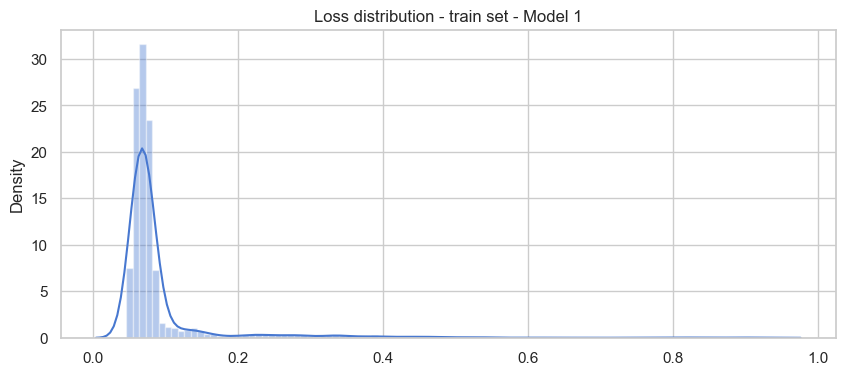

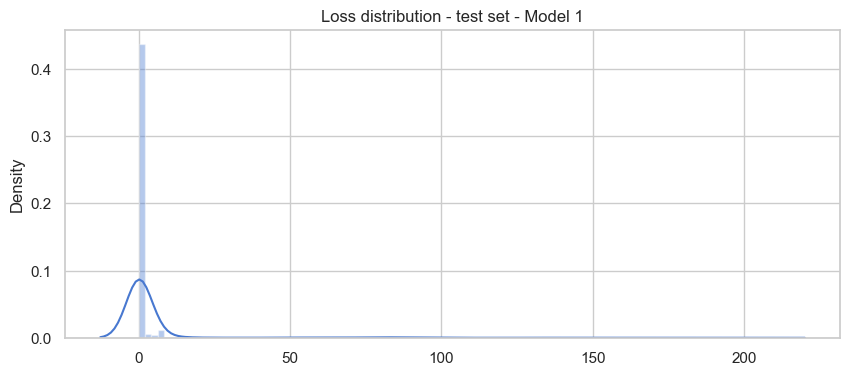

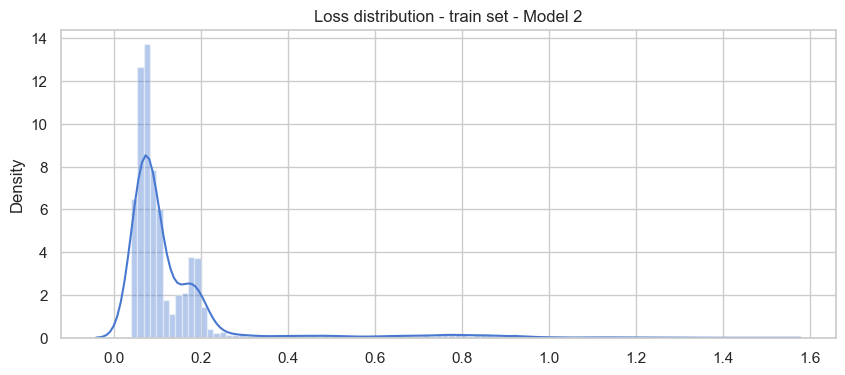

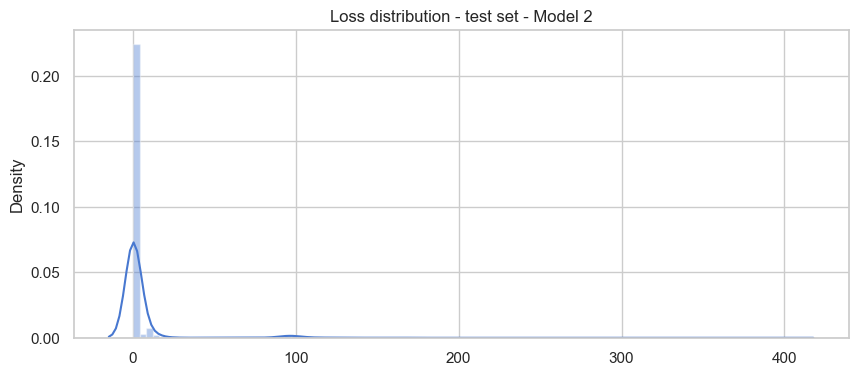

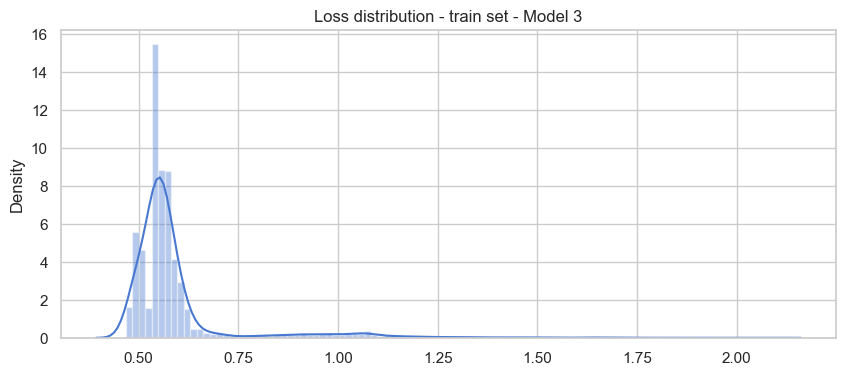

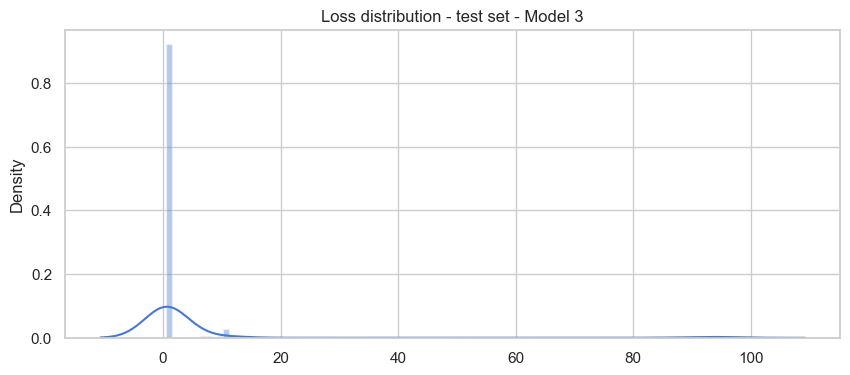

In [72]:
for i in range(len(models)):
  plt.title('Loss distribution - train set - Model {}'.format(i+1))
  sns.distplot(train_mae_losses[i], bins=100, kde=True)
  plt.show()

  plt.title('Loss distribution - test set - Model {}'.format(i+1))
  sns.distplot(test_mae_losses[i], bins=100, kde=True)
  plt.show()

### Selection Threshold

threshold = mean of the loss + 2 standard devation of the loss

In [80]:
test_mae_losses[0].to_numpy().flatten()

array([0.05925912, 0.05760086, 0.06975532, ..., 3.93718275, 4.0903762 ,
       4.20203396])

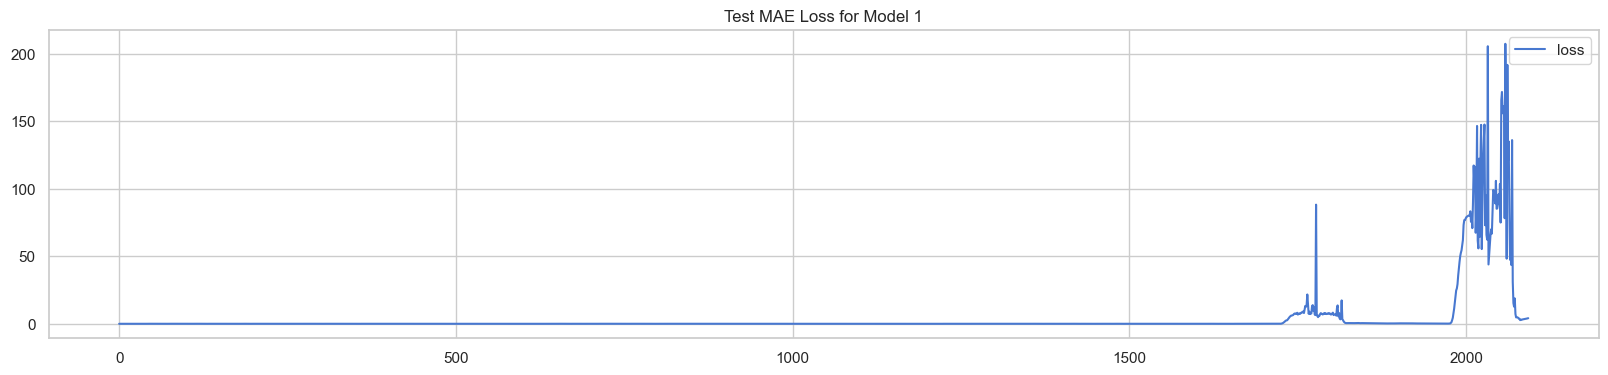

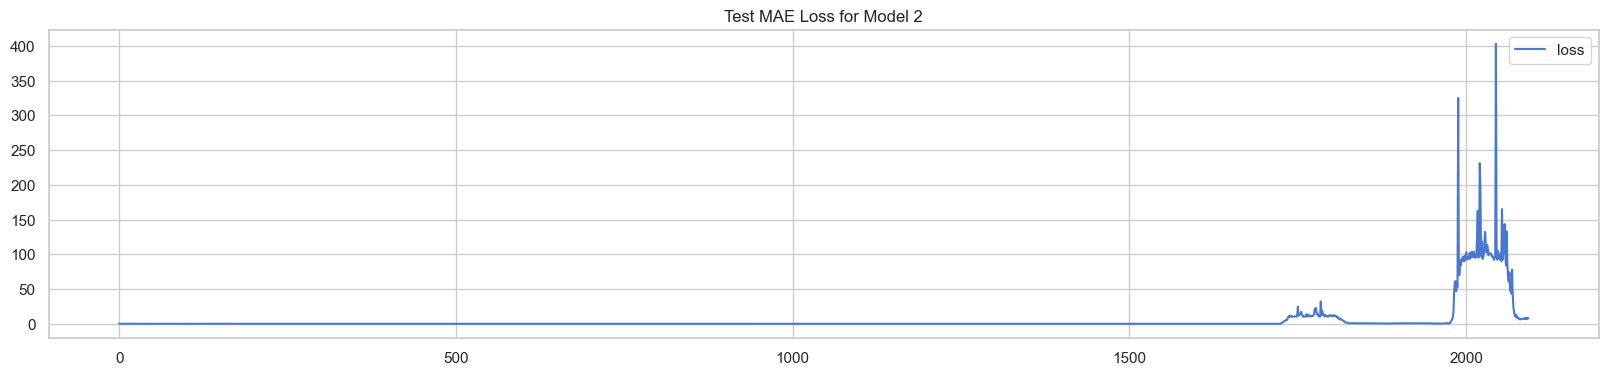

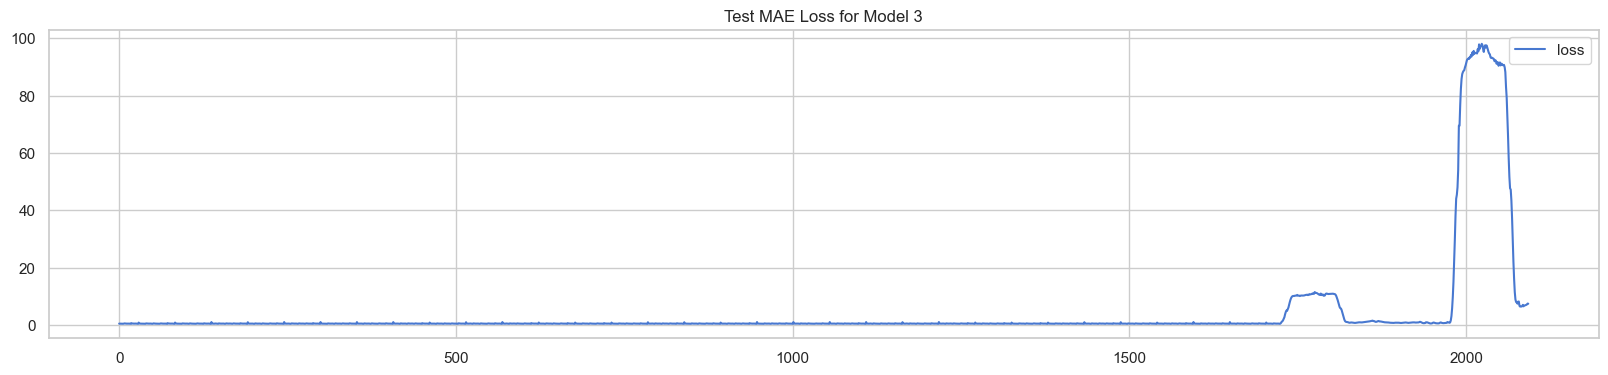

In [83]:
for i in range(len(models)):
  test_mae_loss_array = test_mae_losses[i].to_numpy().flatten()
 
  plt.figure(figsize=(20,4))
  plt.title(f'Test MAE Loss for Model {i+1}')
  plt.plot(test_mae_loss_array, label='loss')
  plt.legend()
  plt.show()

In [85]:
THRESHOLDS = []
for i in range(len(models)):
  print("Model ", i+1)
  th = np.mean(test_mae_losses[i])[0] + 2 * np.std(test_mae_losses[i])[0]
  print(th)
  THRESHOLDS.append(th)

Model  1
43.32826951241853
Model  2
51.106467014360035
Model  3
38.82202973528349


### Loss for each window of the test set vs Threshold

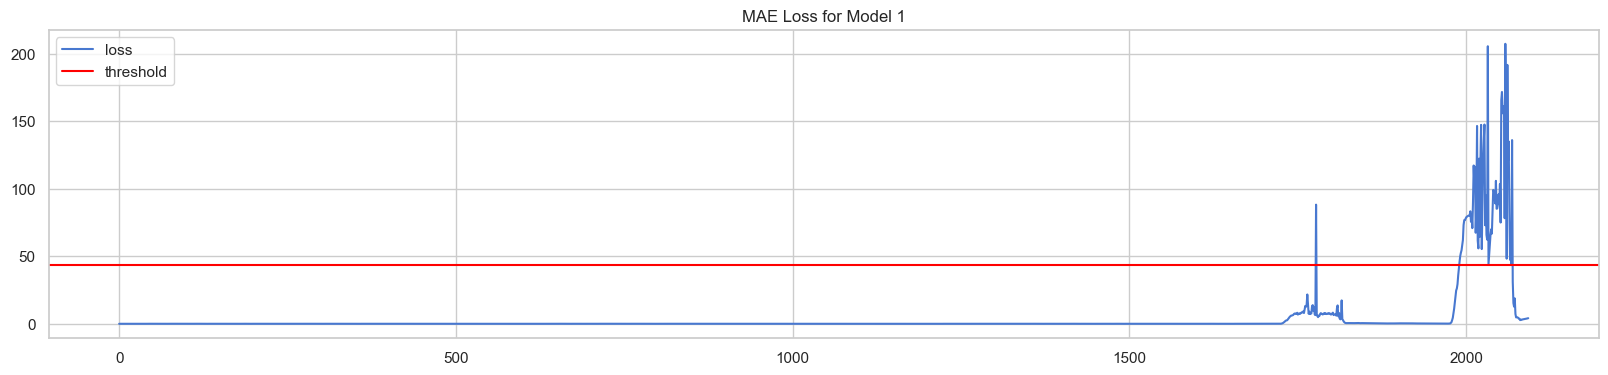

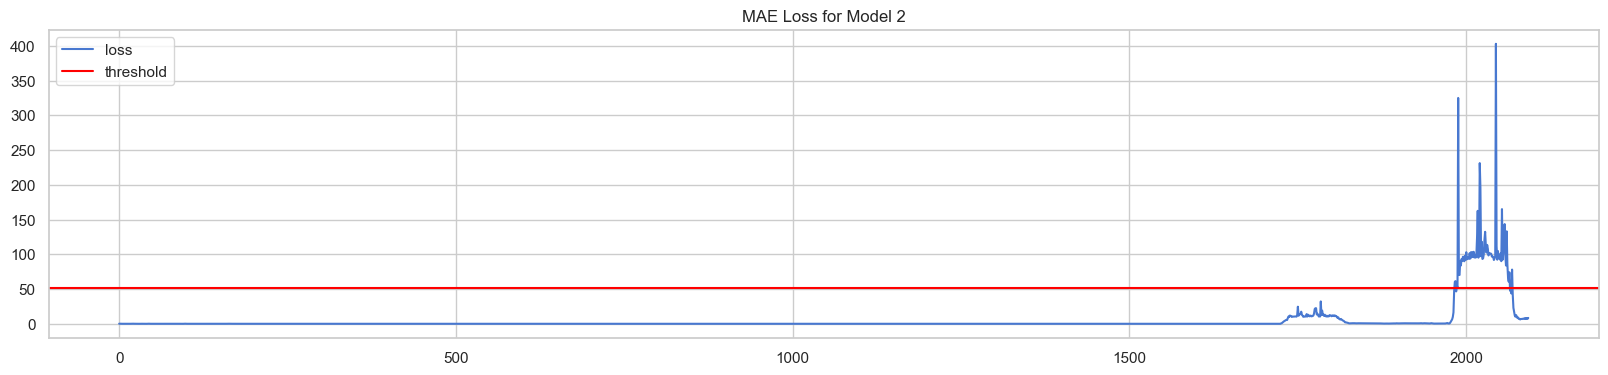

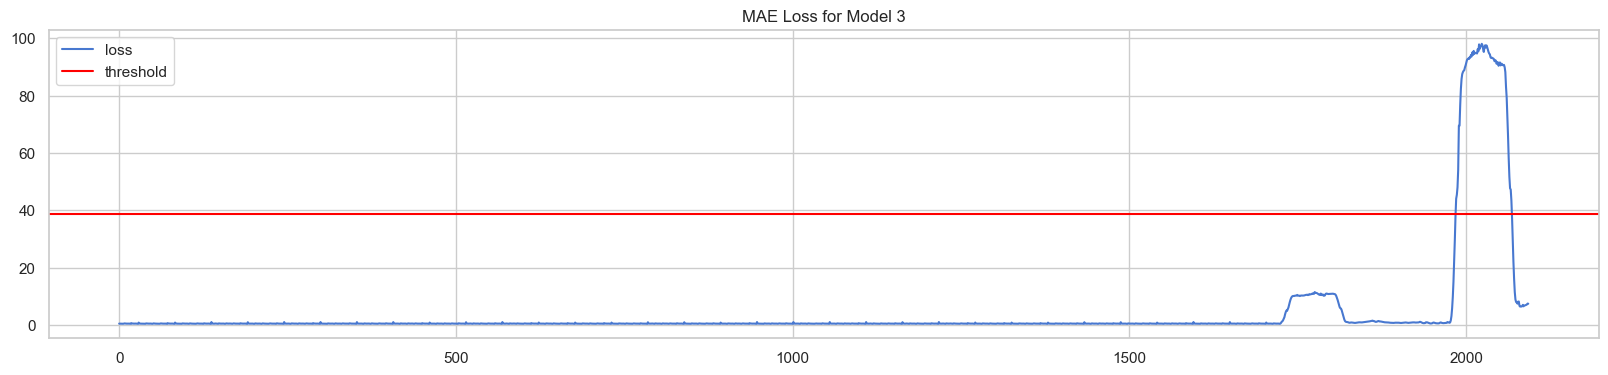

In [86]:
for i in range(len(models)):
  test_mae_loss_array = test_mae_losses[i].to_numpy().flatten()

  plt.figure(figsize=(20,4))
  plt.title(f'MAE Loss for Model {i+1}')
  plt.plot(test_mae_loss_array, label='loss')
  plt.axhline(THRESHOLDS[i], color='red', label='threshold')
  plt.legend()
  plt.show()

### Detected anomalies - plot

In [89]:
time_with_anomalies_per_model = []
for i in range(len(models)):
  y_pred = test_mae_losses[i].to_numpy().flatten() >= THRESHOLDS[i]
  print(y_pred.shape)

  time_test = df.index[train_size:]
  time_test[:-(window_length-1)].shape

  time_with_anomalies = time_test[:-(window_length-1)][y_pred]
  time_with_anomalies_per_model.append(time_with_anomalies)
  print('Time where anomalies have been detected:')
  for d in time_with_anomalies:
    print(d)

(2093,)
Time where anomalies have been detected:
25.752546310424805
26.28500747680664
26.287538528442383
26.29010009765625
26.292600631713867
26.2950382232666
26.29753875732422
26.300037384033203
26.302507400512695
26.305038452148438
26.307538986206055
26.31003761291504
26.31250762939453
26.315038681030273
26.31760025024414
26.320100784301758
26.322538375854492
26.32509994506836
26.327600479125977
26.330007553100586
26.332538604736328
26.335100173950195
26.337600708007812
26.340038299560547
26.342538833618164
26.34503746032715
26.347537994384766
26.350101470947266
26.35260009765625
26.355037689208984
26.357507705688477
26.36003875732422
26.362537384033203
26.36503791809082
26.367515563964844
26.370014190673828
26.372514724731445
26.375015258789062
26.377513885498047
26.380014419555664
26.38251495361328
26.3850154876709
26.387514114379883
26.3900146484375
26.392515182495117
26.39504623413086
26.397546768188477
26.400108337402344
26.402515411376953
26.40507698059082
26.407577514648438
26

In [96]:
indexes_per_models = []
for i in range(len(models)):
  indexes = []
  for d in time_with_anomalies_per_model[i]:
      index_low = np.where(time_test == d)
      indexes.append(index_low[0][0])
  indexes_per_models.append(indexes)

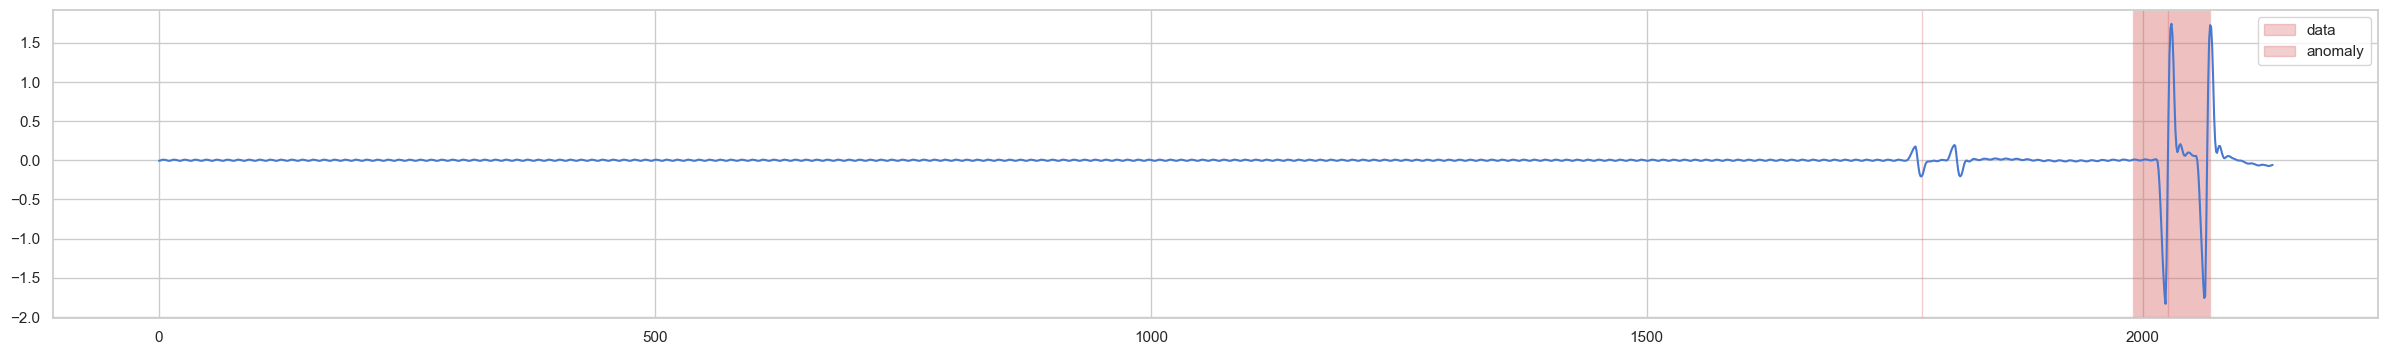

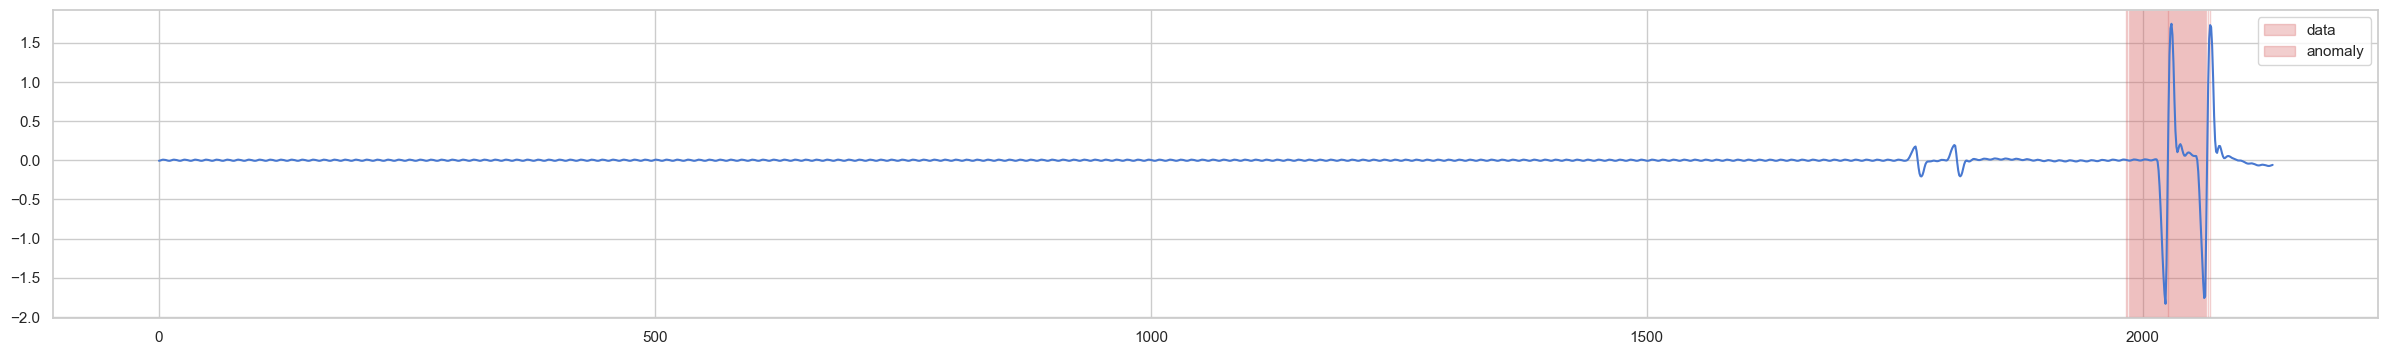

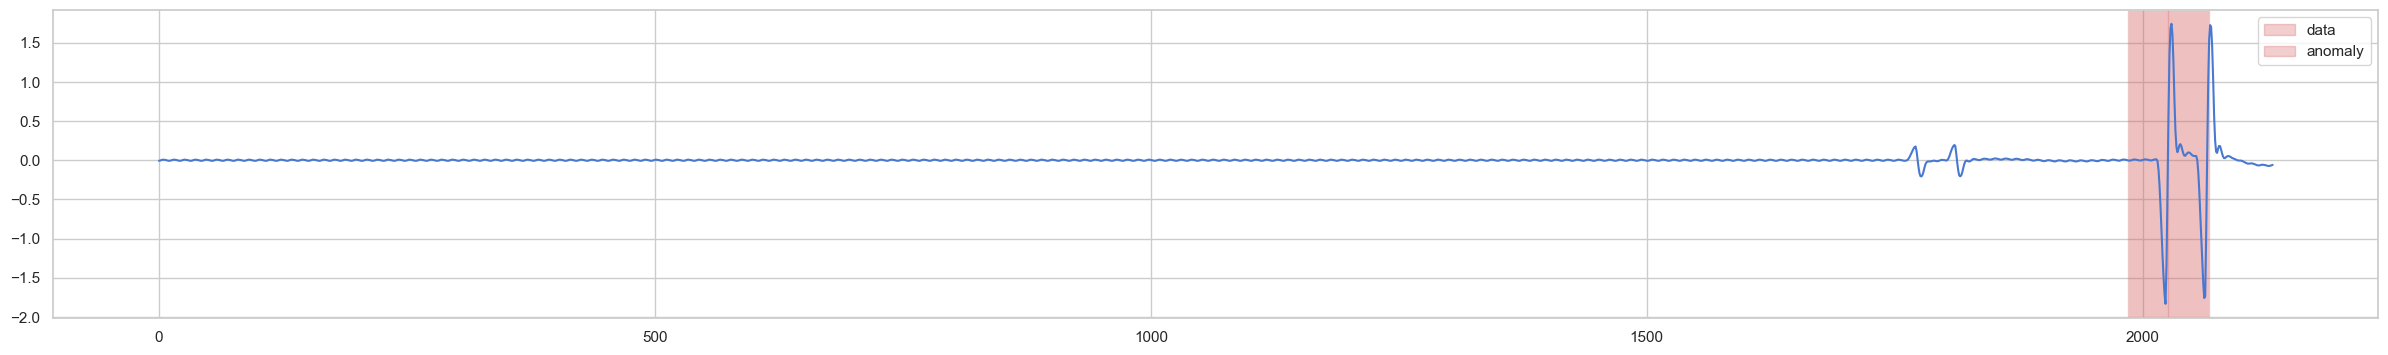

In [97]:
for i in range(len(models)):
    plt.figure(figsize=(30,4))
    for index in indexes_per_models[i]:
        plt.axvspan(index, index, color='r', alpha=0.3)
    plt.plot(scaler.inverse_transform(test).flatten())
    plt.legend(['data', 'anomaly'])
    plt.show()